In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

Modifying the Dataset

In [2]:
from datetime import datetime

data = pd.read_csv('../Datasets/1901-2015/TELANGANA.csv')
data = data.drop(columns=['SUBDIVISION','ANNUAL', 'Jan-Feb','Mar-May','Jun-Sep','Oct-Dec'])

melted_df = pd.melt(data, id_vars=['YEAR'], var_name='MONTH', value_name='RAINFALL')

month_mapping = {
    "JAN": "01", "FEB": "02", "MAR": "03", "APR": "04", "MAY": "05", "JUN": "06",
    "JUL": "07", "AUG": "08", "SEP": "09", "OCT": "10", "NOV": "11", "DEC": "12"
}

melted_df["MONTH"] = melted_df["MONTH"].map(month_mapping)
melted_df["DATE"] = "01-" + melted_df["MONTH"] + "-" + melted_df["YEAR"].astype(str)

final_df = melted_df[['DATE', 'RAINFALL']]
final_df.set_index('DATE', inplace=True)
final_df.index = pd.to_datetime(final_df.index, format='%d-%m-%Y')
final_df.sort_index(inplace=True)
print(len(final_df))
train_data = final_df[:1272]
print(len(train_data))

test_data = final_df[1272:]
print(len(test_data))
print(test_data, train_data)

1380
1272
108
            RAINFALL
DATE                
2007-01-01       0.0
2007-02-01       0.0
2007-03-01       0.1
2007-04-01       0.1
2007-05-01       9.2
...              ...
2015-08-01     160.5
2015-09-01     158.3
2015-10-01      15.6
2015-11-01       0.3
2015-12-01       1.7

[108 rows x 1 columns]             RAINFALL
DATE                
1901-01-01       6.9
1901-02-01      41.8
1901-03-01       7.8
1901-04-01      45.2
1901-05-01      22.0
...              ...
2006-08-01     308.2
2006-09-01     280.2
2006-10-01      28.1
2006-11-01      34.7
2006-12-01       0.0

[1272 rows x 1 columns]


C:\Users\Manasa Swamireddy\AppData\Local\Temp\ipykernel_2348\3917673355.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.sort_index(inplace=True)


<Axes: xlabel='DATE'>

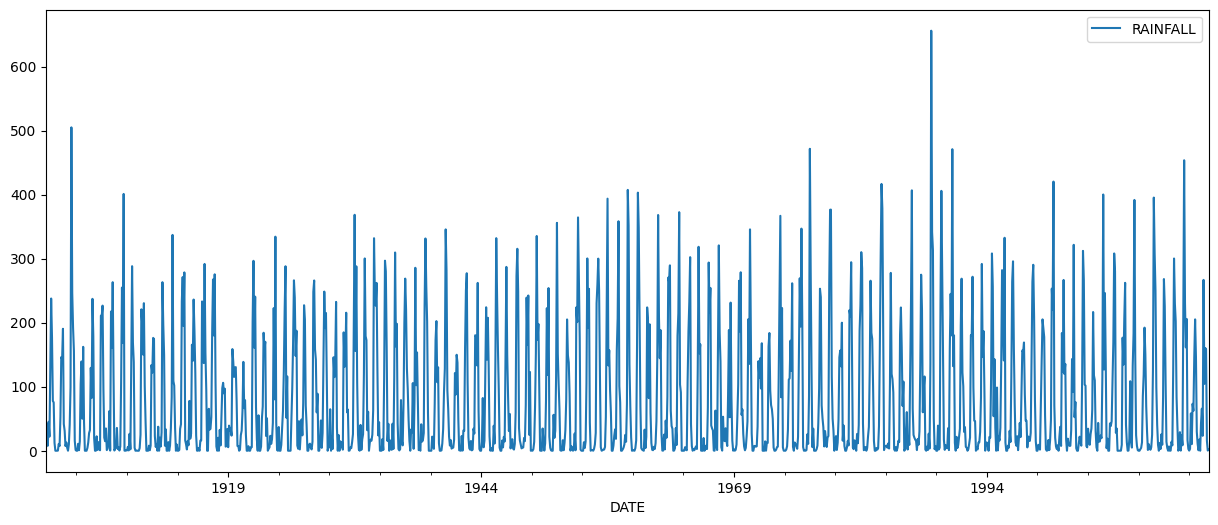

In [3]:
import matplotlib.pyplot as plt

final_df.plot(figsize=(15, 6))

In [4]:
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.fit_transform(test_data)

print('Shape of train data: ', scaled_train_data.shape)
print('Shape of test data: ', scaled_test_data.shape)

Shape of train data:  (1272, 1)
Shape of test data:  (108, 1)


Converting timeseries data into input and labels

In [5]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []

    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    
    return np.array(dataX), np.array(dataY)

In [6]:
look_back = 12
X_train, y_train = create_dataset(scaled_train_data, look_back)
X_test, y_test = create_dataset(scaled_test_data, look_back)

In [7]:
print('Shape of X_train: ', X_train.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_test: ', y_test.shape)

Shape of X_train:  (1259, 12)
Shape of y_train:  (1259,)
Shape of X_test:  (95, 12)
Shape of y_test:  (95,)


In [8]:
#Reshaping the data

X_train = np.reshape(X_train,(X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test,(X_test.shape[0], 1, X_test.shape[1]))

print('Shape of X_train: ', X_train.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_test: ', y_test.shape)

Shape of X_train:  (1259, 1, 12)
Shape of y_train:  (1259,)
Shape of X_test:  (95, 1, 12)
Shape of y_test:  (95,)


In [9]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import regularizers

# Create the LSTM model
model = Sequential()

input_shape = (X_train.shape[1], X_train.shape[2])

for units in (128, 64, 32):
    model.add(LSTM(units=units, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Dense(units=units, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    input_shape = (units,)

model.add(LSTM(units=16, return_sequences=False))
model.add(Dropout(0.2))

# Add a dense output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
model.summary()

c:\Users\Manasa Swamireddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        72,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1, 128)         │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1, 32)          │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,897 (620.69 KB)

 Trainable params: 158,897 (620.69 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
import h5py

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_weights.keras', monitor='loss',mode='min', save_best_only=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    verbose=1,
    callbacks=[model_checkpoint]
)

Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.2525
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2200
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1882
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1668
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1492
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1304
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1117
Epoch 8/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0970
Epoch 9/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0857
Epoch 10/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0765
Epoch 11/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0682
Epoch 12/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0611
Epoch 13/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0555
Epoch 14/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0491
Epoch 15/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.04

In [11]:
best_model = tf.keras.models.load_model('best_model_weights.keras')

# Make predictions
train_predict = best_model.predict(X_train)
test_predict = best_model.predict(X_test)

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [12]:
train_predict.shape

(1259, 1)

In [13]:
train_predict = train_predict.reshape(train_predict.shape[0], train_predict.shape[1])
trainPredict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = test_predict.reshape(test_predict.shape[0], test_predict.shape[1])
testPredict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])


In [14]:
# #Inverse transforming the data

# train_predict = scaler.inverse_transform(train_predict)

In [15]:
import math
from sklearn.metrics import mean_squared_error
#Calculating rmse for train and test predictions
trainScore = math.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
print('Train RMSE: %.2f' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Train RMSE: 88.69
Test RMSE: 130.94


In [16]:
dates = pd.date_range(start='1901-01-01', freq='MS',periods=y_train.shape[1])

len(dates)

1259

In [17]:
trainActual = pd.DataFrame({'Rainfall' : y_train[0]})
trainActual.index = dates

trainPredicted = pd.DataFrame({'Rainfall' : trainPredict[:,0]})
trainPredicted.index = dates

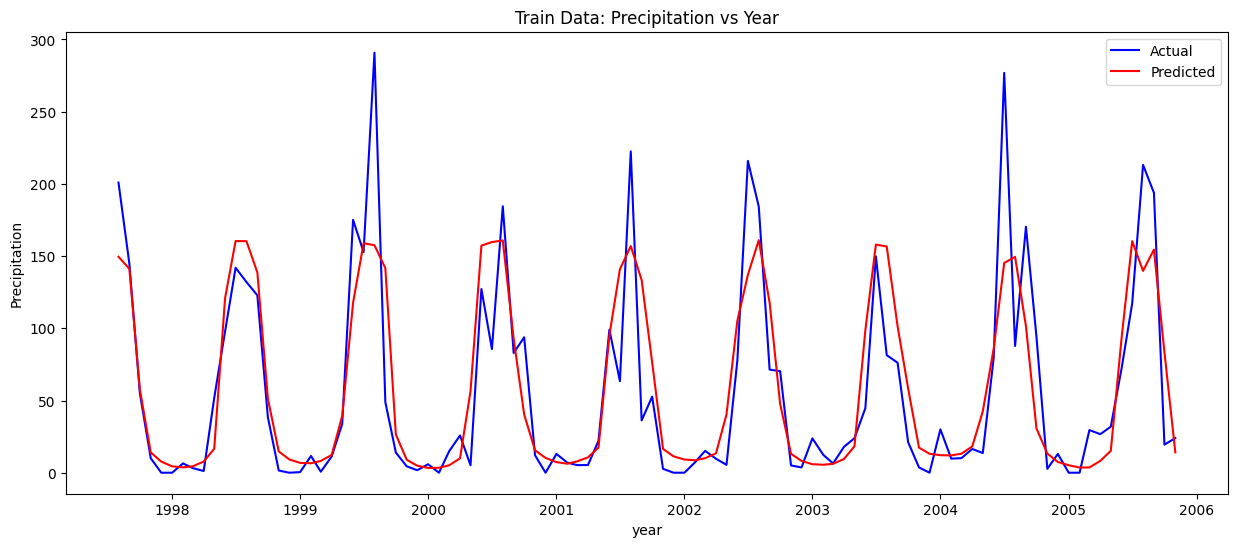

In [18]:
plt.figure(figsize=(15, 6))
plt.plot(trainActual[-100:], label='Actual', color='blue')
plt.plot(trainPredicted[-100:], label='Predicted', color='red')
plt.title('Train Data: Precipitation vs Year')
plt.xlabel('year')
plt.ylabel('Precipitation')
plt.legend()

In [19]:
test_dates = pd.date_range(start='2007-01-01', freq='MS',periods=y_test.shape[1])

In [20]:
testActual = pd.DataFrame({'Rainfall' : y_test[0]})
testActual.index = test_dates

testPredicted = pd.DataFrame({'Rainfall' : testPredict[:,0]})
testPredicted.index = test_dates

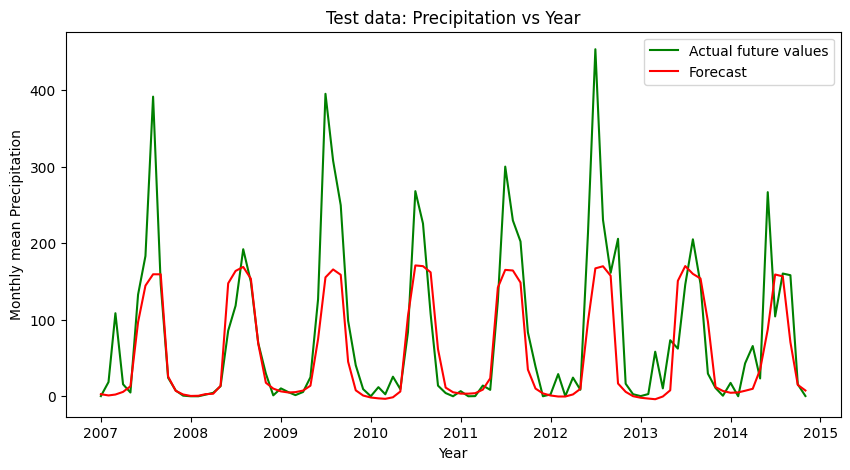

In [21]:
plt.figure(figsize=(10,5))
plt.plot(testActual, color='green', label='Actual future values')
plt.plot(testPredicted, color='red', label='Forecast')
plt.title('Test data: Precipitation vs Year')
plt.xlabel('Year')
plt.ylabel('Monthly mean Precipitation')
plt.legend(loc='best')

Loss: 0.007659010589122772
Train RMSE: 88.69
Test RMSE: 130.94


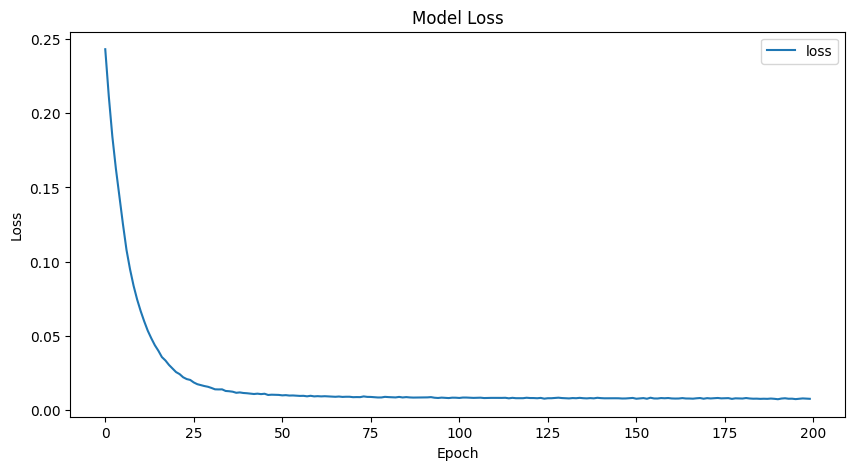

In [22]:
#Evaluation of the model
#Loss and rmse values
history.history.keys()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

#Loss value of the model
loss = history.history['loss']
print('Loss:', loss[-1])

#RMSE
print('Train RMSE: %.2f' % (trainScore))
print('Test RMSE: %.2f' % (testScore))
